---
---
---
# **Fake News Classification**
## Max Mager, Teo Förste, Vladislav Antonov | Prof. Dr. Grüttmüller | Mustererkennung SS25
---
---
---


---
---
---
## **Motivation**
---
---
---

![Alt-Text](./Bilder/FakeGates.png)

<small> 
- Imgur (o. D.): Is it me or does Bill Gates look like he’s at a solid [7] here?, Imgur, [online] https://imgur.com/is-me-does-bill-gates-look-like-hes-solid-7-here-vlMjEgF [abgerufen am 06.06.2025]
- LibGuides: Fake News: Examples (o. D.): [online] https://library-nd.libguides.com/fakenews/examples [abgerufen am 06.06.2025]
</small>

![Alt-Text](./Bilder/FakeProtest.png)

<small>  
- LibGuides: Fake News: Examples (o. D.): [online] https://library-nd.libguides.com/fakenews/examples [abgerufen am 06.06.2025]
- Evon, Dan (2017): FACT CHECK: Black Lives Matter „Thugs“ blocked emergency crews from reaching hurricane victims?, Snopes, [online] https://www.snopes.com/fact-check/black-lives-matter-emergency-crews-hurricane/ [abgerufen am 06.06.2025].
</small>

![Alt-Text](./Bilder/FakePapst.png)

___

<small> 
- Hannah Ritchie, Special to CNBC.com (2016): Read all about it: The biggest fake news stories of 2016, CNBC, [online] https://www.cnbc.com/2016/12/30/read-all-about-it-the-biggest-fake-news-stories-of-2016.html [abgerufen am 06.06.2025]
- LibGuides: Fake News: Examples (o. D.): [online] https://library-nd.libguides.com/fakenews/examples [abgerufen am 06.06.2025] 
</small>

---
---
---
## **Datasets von *Huggingface* und *Kaggle***
---
---
---

| Eigenschaften\Dataset | Fake News Classification             | fake_news       | fake-news-detection-dataset-English | Fake News Detection |
|-----------------------|--------------------------------------|-----------------|-------------------------------------|---------------------|
| Ersteller*in          | Saurabh Shahane                      | Gonzalo Álvarez | Erfan Moosavi Monazzah              | Bhavik Jikadara     |
| Veröffentlicht        | 2021                                 | 2021            | 2023                                | 2024                |
| Einträge gerundet ~   | 72000                                | 41000           | 44000                               | 45000               |
| Zusammenstellung      | Reuters, Kaggle, McIntire, Buzzfeed  | Kaggle, Reuters | Kaggle                              | Unbekannt           |
| Quelle                | [1]                                  | [2]             | [3]                                 | [4]                 |

<small>
- [1] Fake news classification (2023): Kaggle, [online] https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification [abgerufen am 06.06.2025]
- [2] GonzaloA/fake_news · Datasets at Hugging Face (2024): [online] https://huggingface.co/datasets/GonzaloA/fake_news [abgerufen am 06.06.2025]
- [3] ErfanMoosaviMonazzah/fake-news-detection-dataset-English · Datasets at Hugging Face (2024): [online] https://huggingface.co/datasets/ErfanMoosaviMonazzah/fake-news-detection-dataset-English [abgerufen am 06.06.2025]
- [4] Fake news detection (2023): Kaggle, [online] https://www.kaggle.com/datasets/bhavikjikadara/fake-news-detection [abgerufen am 08.06.2025]
</small>

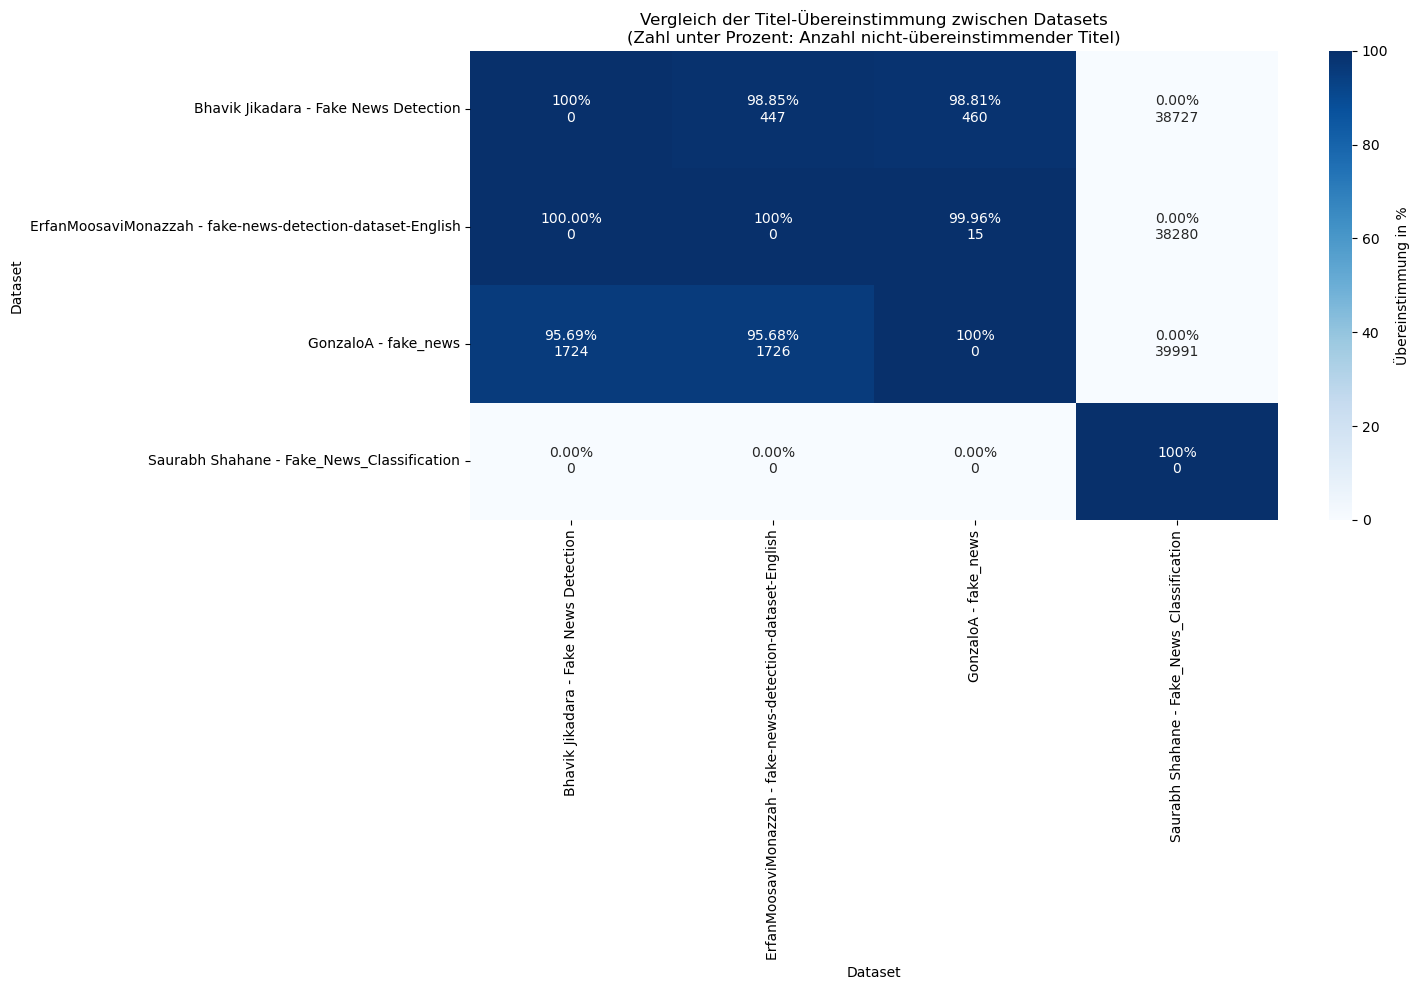

In [13]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

base_path = '../src/data'
datasets = {}

def read_titles(filepath, dataset_name):
    # Sonderbehandlung für den Datensatz "Saurabh Shahane - Fake_News_Classification"
    if dataset_name.lower() == 'saurabh shahane - fake_news_classification':
        try:
            df = pd.read_csv(filepath, sep=',', usecols=['title'], dtype=str)
            return df['title'].dropna().astype(str).str.strip().str.lower().tolist()
        except Exception:
            return []

    # Standardverarbeitung
    for sep in [',', ';', '\t']:
        try:
            df = pd.read_csv(filepath, sep=sep, engine='python', usecols=['title'], dtype=str)
            return df['title'].dropna().astype(str).str.strip().str.lower().tolist()
        except Exception:
            continue
    return []

# Lade alle Datasets ein
folders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]

for folder in folders:
    folder_path = os.path.join(base_path, folder)
    all_titles = []
    files = glob.glob(os.path.join(folder_path, '*'))

    for filepath in files:
        titles = read_titles(filepath, folder)
        all_titles.extend(titles)

    unique_titles = set(all_titles)
    datasets[folder] = unique_titles

# Berechne Übereinstimmungsmatrix
result = pd.DataFrame(index=datasets.keys(), columns=datasets.keys(), dtype=float)
dataset_names = list(datasets.keys())

for i, a in enumerate(dataset_names):
    for b in dataset_names[i+1:]:
        titles_a = datasets[a]
        titles_b = datasets[b]

        if len(titles_a) == 0:
            score_ab = 0.0
        else:
            inter_ab = len(titles_a.intersection(titles_b))
            score_ab = (inter_ab / len(titles_a)) * 100

        if len(titles_b) == 0:
            score_ba = 0.0
        else:
            inter_ba = len(titles_b.intersection(titles_a))
            score_ba = (inter_ba / len(titles_b)) * 100

        result.loc[a, b] = score_ab
        result.loc[b, a] = score_ba

for name in dataset_names:
    result.loc[name, name] = 100.0

result = result.round(2)

# Erstelle Annotationen mit Prozent und Anzahl nicht-übereinstimmender Einträge
annot = result.copy().astype(str)

for i, a in enumerate(dataset_names):
    for j, b in enumerate(dataset_names):
        if a == b:
            annot.loc[a, b] = f"100%\n0"
        else:
            titles_a = datasets[a]
            titles_b = datasets[b]
            inter_ab = titles_a.intersection(titles_b)
            unmatched_count = len(titles_a - titles_b)  # Aus Sicht von Dataset a
            percent = result.loc[a, b]
            annot.loc[a, b] = f"{percent:.2f}%\n{unmatched_count}"

# Plot
plt.figure(figsize=(15, 10))
sns.heatmap(result, annot=annot.values, fmt="", cmap='Blues', cbar_kws={'label': 'Übereinstimmung in %'})
plt.title('Vergleich der Titel-Übereinstimmung zwischen Datasets\n(Zahl unter Prozent: Anzahl nicht-übereinstimmender Titel)')
plt.xlabel('Dataset')
plt.ylabel('Dataset')
plt.tight_layout()
plt.show()



---
---
---
## **Max:
Varianten von one-class vergleichen
local outlier factor gewinnt kurz erklären 
hyperparameter Tuning (erklären und kurz zeigen)
Auswertung mit verschiedenen Datensätzen
Vergleich durch benutzung von allen Kombinationen von Datensätzen
auf Modell mit besten Trainingsdaten**
---
---
---


---
---
---
## **Teo**
Ansatz: NLP mit SpaCy, Training mit BERT (DistilBert)  
Genauigkeit (F1):
- Gonzalo nach 1 Epoche: 98,46 %
- Saurabh nach 2 Epochen: 98,87 %  

TODO:
- restliche Datensätze trainieren
- Hyperparameteranpassung
- testen gegen unbekannte Daten
---

# Natural Language Processing angewandt auf Saurabh Shahane
___

In [5]:
# Imports
import pandas as pd
import spacy
import torch
import transformers
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import TrainingArguments, Trainer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from datasets import Dataset
from pandarallel import pandarallel

In [6]:
# Version Checks
print("Pandas version:", pd.__version__)
print("SpaCy version:", spacy.__version__)
print("Transformers version:", transformers.__version__)
print("Torch version:", torch.__version__)
print("Cuda version:", torch.version.cuda)

if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

# Initialize Parallelization
pandarallel.initialize(progress_bar=True)

Pandas version: 2.3.0
SpaCy version: 3.8.7
Transformers version: 4.52.4
Torch version: 2.5.1+cu121
Cuda version: 12.1
GPU: NVIDIA GeForce RTX 2060 SUPER
INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [8]:
# Data Path
csv_path = "../src/data/Saurabh Shahane - Fake_News_Classification/WELFake_Dataset.csv"

# Read with semicolon separator
df = pd.read_csv(csv_path, sep=',')

# Split Data
df_train, df_temp = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42, stratify=df_temp['label'])

# Quick sanity check
print("Train:", df_train.shape)
print("Eval: ", df_val.shape)
print("Test: ", df_test.shape)

# first 5 rows of dataset
print(df_train.head(5))

Train: (50493, 4)
Eval:  (10820, 4)
Test:  (10821, 4)
       Unnamed: 0                                              title  \
24388       24388  THE FACE OF THE DEMOCRAT PARTY Has A Message F...   
40608       40608  INCOMING FRESHMEN Are Put On Notice With Welco...   
66652       66652  REPUBLICANS CALL FOR ANSWERS: Did Wasserman-Sc...   
71224       71224  EXTORTION? HOW IRAN Used Nuke Deal To Force Ob...   
17060       17060  Democrats want strong response to intel report...   

                                                    text  label  
24388  This ass-clown reminds us of why term limits a...      1  
40608  Wow! The University of Chicago sends impressiv...      1  
66652  Busted! Even moderate Republican Susan Collins...      1  
71224  If I were a European and was forced to deal wi...      1  
17060  WASHINGTON (Reuters) - The top Democrats on th...      0  


In [9]:
# Define Preprocessing
def preprocess_text(text):
    import spacy
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

In [10]:
# Test Preprocessing (can be skipped)
df_train_sample = df_train[:5]['text'].astype(str).apply(preprocess_text)

with pd.option_context('display.max_colwidth', None):
    print(df_train_sample)

24388                                                                                                                                                                                                                                                                                                                                                                                        ass clown remind term limit important leisa see rep. rangel d ny close personal week visit capitol building guest rep. mike bishop r mi shock people elect represent nation 20 house member look like roam hall nursing home   hall congress   people business make decision behalf country charlie rangel perfect example assertion s secret democrats t stand tea party rarely express hatred loud like rep. charlie rangel moment catch camera democrat congressman let reporter know think coalition citizen believe individual liberty small government undoubtedly constituents).theblaze report rep. charlie rangel d n.y. harsh wor

In [ ]:
# Apply Preprocessing
df_train['text'] = df_train['text'].astype(str).parallel_apply(preprocess_text)
df_test['text'] = df_test['text'].astype(str).parallel_apply(preprocess_text)

print(df_train['text'].head(5))

In [ ]:
# Load Tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Tokenizing
train_encodings = tokenizer(list(df_train['text']), truncation=True, padding=True)
test_encodings = tokenizer(list(df_test['text']), truncation=True, padding=True)

In [ ]:
# Translate to Huggingface Dataset Format
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'label': list(df_train['label'])
})

test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'label': list(df_test['label'])
})

# Load Model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Training Parameters
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    save_strategy="epoch",
    fp16=True,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

# Define Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.argmax(torch.tensor(logits), dim=1)
    report = classification_report(labels, preds, output_dict=True)
    return {
        "accuracy": report["accuracy"],
        "f1": report["weighted avg"]["f1-score"]
    }

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Start Training
trainer.train()

# Evaluation
predictions = trainer.predict(test_dataset)
pred_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1)
print(classification_report(df_test['label'], pred_labels))

---
---
---

# Multiple Logistische Regression
___

- Anwendung auf nominalskalierte Kriterien
  - in unserem Fall binär logistisch --> Real = 0 oder Fake = 1 (oder andersherum)
- mehrere Prädiktoren bestehend aus Verknüpfung von Titel + Text
- sagt aus wie wahrscheinlich Real oder Fake
- Feature-Dimension wird durch TfidfVectorizer erstellt

Die allgemeine Formel der multiplen logistischen Regression lautet:

$$
P(Y = 1 \mid \mathbf{x}) = \frac{1}{1 + e^{-\mathbf{x}^\top \boldsymbol{\beta}}}
$$

- **$\mathbf{x} = (x_1, x_2, \dots, x_n)$**  
  Merkmalsvektor eines Artikels, erstellt mit `TfidfVectorizer`.  
  Jeder Eintrag $x_i$ ist der TF-IDF-Wert eines bestimmten Wortes aus Titel und Text.

- **$\boldsymbol{\beta} = (\beta_0, \beta_1, \dots, \beta_n)$**  
  Regressionskoeffizienten des Modells.  
  $\beta_i$ gibt an, wie stark das Merkmal $x_i$ (ein Wort) zur Vorhersage "Fake News" beiträgt.

- **$\beta_0$**  
  Bias-Term (Grundwahrscheinlichkeit ohne Einfluss der Merkmale).

> **Beispiel:**  
> Wenn "clickbait" im Artikel nicht vorkommt ($x_1 = 0$) und "vaccine" häufig ($x_2 = 0{,}15$), dann fließen diese Werte gewichtet durch $\beta_1$, $\beta_2$ in die Entscheidung ein.

**Ziel:**  
Schätzung der Wahrscheinlichkeit, dass ein Artikel Fake News ist:





<small>Multiple regression (o. D.): [Studyflix] https://studyflix.de/statistik/multiple-regression-2149 [abgerufen am 09.06.2025].</small>

___
## Term Frequency-Inverse Document Frequency (TF-IDF) Vektorisierer
___

- Verfahren zur Gewichtung von Wörtern in Texten
- Textklassifikation, Information Retrieval, Themenmodellierung

### TF
- TF(t, d) = (Anzahl von t in d) / (Gesamtanzahl Wörter in d)
  - t: Term/Wort
  - d: Dokument 
- Ziel: Häufige Begriffe im Dokument hervorheben.

### IDF
- IDF(t) = log((N + 1) / (df(t) + 1)) + 1
    - N:     Gesamtanzahl Dokumente
    - df(t): Anzahl Dokumente, die den Begriff t enthalten
-Ziel: Häufige Begriffe im Korpus abwerten (z. B. „the“, „and“).

### Tensorflow
- Tensorflow hat dafür öffentliche Bibliothek bereitgestellt
- verschiedene Parameter wie Featuregröße, Normalsierungen, Sprache..

<small>Anurag (2024): TF-IDF Vectorizer explained - Anurag - medium, in: Medium, 27.11.2024, [online] https://medium.com/@gusainanurag58/tf-idf-vectorizer-explained-373b3f07d23b.</small>

___
# Multiple Logistische Regression angewandt auf GonzaloA
___

In [25]:
import pandas as pd
import numpy as np

# Train/validation split
from sklearn.model_selection import train_test_split

# Text feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Classifier and evaluation metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Pipeline utilities
from sklearn.pipeline import Pipeline

In [26]:
# Load each split from local CSVs
# Adjust the paths if needed
train_path = "../src/data/GonzaloA - fake_news/train.csv"
val_path   = "../src/data/GonzaloA - fake_news/evaluation.csv"
test_path  = "../src/data/GonzaloA - fake_news/test.csv"

df_train = pd.read_csv(train_path, sep=';')
df_val   = pd.read_csv(val_path,   sep=';')
df_test  = pd.read_csv(test_path,  sep=';')

In [27]:
# Merge text fields
def merge_text(row):
    return f"{row['title']} \n{row['text']}"

for df in [df_train, df_val, df_test]:
    df['input_text'] = df.apply(merge_text, axis=1)

# Define X and y
X_train, y_train = df_train['input_text'], df_train['label']
X_val,   y_val   = df_val['input_text'],   df_val['label']
X_test,  y_test  = df_test['input_text'],  df_test['label']  # y_test only for evaluation

In [28]:
# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    max_features=40_000,    # Keep only the top 40,000 most frequent terms to limit dimensionality
    ngram_range=(1,2),      # Include both unigrams (single words) and bigrams (pairs of words)
    stop_words='english',   # Remove common English stop words (e.g., 'the', 'and')
    lowercase=False
)

# Fit the vectorizer on the training data and transform texts to sparse matrices
# fit_transform learns the vocabulary from X_train and then transforms X_train
X_train_tfidf = vectorizer.fit_transform(X_train)

# Use the already-fit vectorizer to transform validation and test sets
# transform uses the learned vocabulary to convert new texts into vectors
X_val_tfidf   = vectorizer.transform(X_val)
X_test_tfidf  = vectorizer.transform(X_test)

In [29]:
pipeline = Pipeline([
    ('tfidf', vectorizer),
    ('clf', LogisticRegression(max_iter=1000))
])

# Train
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(lowercase=False, max_features=40000,
                                 ngram_range=(1, 2), stop_words='english')),
                ('clf', LogisticRegression(max_iter=1000))])

In [30]:
# Generate predictions on the test set using our trained pipeline
# `test_preds` will be an array of predicted labels: 0 = real, 1 = fake
test_preds = pipeline.predict(X_test)

# If the true labels for the test split (`y_test`) are available, evaluate performance:
# Print overall accuracy to see the fraction of correct predictions
print("Test Accuracy:", accuracy_score(y_test, test_preds))

# Print a detailed classification report (precision, recall, F1-score) for each class
print(classification_report(
    y_test,             # True labels
    test_preds,         # Predicted labels
    target_names=['Real','Fake']
))

Test Accuracy: 0.9785635086854749
              precision    recall  f1-score   support

        Real       0.98      0.97      0.98      3753
        Fake       0.98      0.98      0.98      4364

    accuracy                           0.98      8117
   macro avg       0.98      0.98      0.98      8117
weighted avg       0.98      0.98      0.98      8117



In [31]:
# Create a DataFrame pairing each test article with its predicted label
submission = pd.DataFrame({
    'text': df_test['text'],            # Raw text from the test set
    'predicted_label': test_preds       # Model output: 0 = real, 1 = fake
})
# Export the predictions to CSV for review or submission (no index column)
submission.to_csv('fake_news_predictions.csv', index=False)

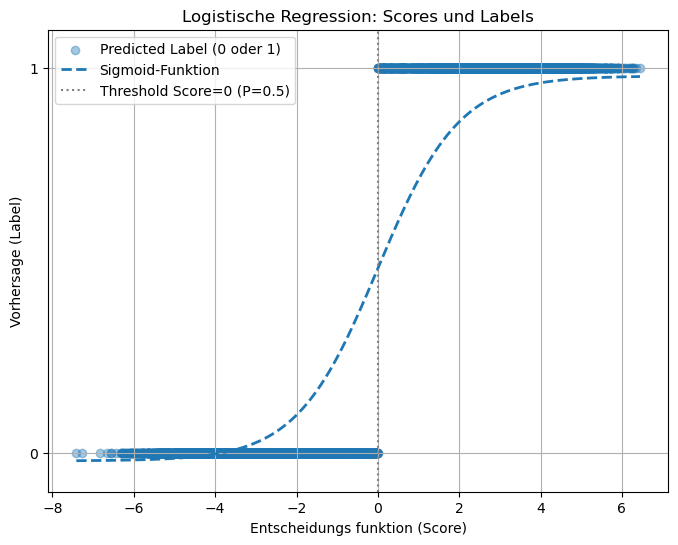

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Entscheidungsscores und Vorhersagen für die Validierungsdaten
dec_scores  = pipeline.decision_function(X_val)   # Roh-Score (logits)
pred_labels = pipeline.predict(X_val)             # Labels: 0 oder 1

plt.figure(figsize=(8, 6))

# Punkte: Score vs. Label
plt.scatter(dec_scores, pred_labels, alpha=0.4, label='Predicted Label (0 oder 1)')

# Ideale Sigmoid-Kurve (zur Orientierung leicht angesenkt)
x = np.linspace(dec_scores.min(), dec_scores.max(), 300)
sigmoid = 1 / (1 + np.exp(-x))
# Wir verschieben die Kurve um –0.02, damit sie nicht genau auf den Punkten liegt
plt.plot(x, sigmoid - 0.02, linestyle='--', linewidth=2, label='Sigmoid-Funktion')

# Threshold-Linie bei Score = 0 (entspricht P=0.5)
plt.axvline(0, color='gray', linestyle=':', label='Threshold Score=0 (P=0.5)')

plt.yticks([0, 1])
plt.ylim(-0.1, 1.1)
plt.xlabel('Entscheidungs funktion (Score)')
plt.ylabel('Vorhersage (Label)')
plt.title('Logistische Regression: Scores und Labels')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


# Random Forest

- **Anwendung auf nominalskalierte Kriterien, Mehrere Prädiktoren und Angabe einer Wahrscheinlichkeit wie bei Logistic Regression**

- **Ensemble aus vielen Entscheidungsbäumen**  
  - Jeder Baum $h_t$ trifft eine Ja/Nein-Entscheidung („Real“ vs. „Fake“) basierend auf Schwellwerten der TF-IDF-Merkmale  
  - Die Bäume werden auf zufälligen Teilmengen von Daten und Features trainiert („Bootstrap“ + „Feature-Bagging“)


#### Formel: Vorhersagewahrscheinlichkeit im Random Forest

$$
P(Y = 1 \mid \mathbf{x})
= \frac{1}{T} \sum_{t=1}^{T} h_t(\mathbf{x})
$$

- $\mathbf{x} = (x_1, x_2, \dots, x_n)$  
  Merkmalsvektor eines Artikels, erstellt mit `TfidfVectorizer`.

- $T$ = Anzahl der Entscheidungsbäume im Wald  
- $h_t(\mathbf{x}) \in \{0,1\}$ = Vorhersage des $t$-ten Baums (0 = Real, 1 = Fake)


> **Beispiel:**  
> Angenommen, von $T = 100$ Bäumen geben 70 die Vorhersage „Fake“ zurück:  
> 
> $$
> P(Y = 1 \mid \mathbf{x}) = \frac{70}{100} = 0{,}7
> $$  
> 
> → Die Modellvorhersage ist: **70 % Wahrscheinlichkeit**, dass der Artikel Fake News ist.


#### Ziel:
Schätzung der Wahrscheinlichkeit, dass ein Artikel Fake News ist – basierend auf dem Votum vieler Entscheidungsbäume.


![Alt-Text](./Bilder/random-forest.jpg)

<small> Anas Brital | Random Forest algorithm explained . (o. D.): [online] https://anasbrital98.github.io/blog/2021/Random-Forest/ [abgerufen am 09.06.2025]. </small>

___
# Random Forest Regression angewandt auf GonzaloA
___

In [39]:
import pandas as pd
import numpy as np

# Train/validation split
from sklearn.model_selection import train_test_split

# Text feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Classifier and evaluation metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Pipeline utilities (optional)
from sklearn.pipeline import Pipeline

In [40]:
# Load each split from local CSVs
# Adjust the paths if needed
train_path = "../src/data/GonzaloA - fake_news/train.csv"
val_path   = "../src/data/GonzaloA - fake_news/evaluation.csv"
test_path  = "../src/data/GonzaloA - fake_news/test.csv"

# Read with semicolon separator
df_train = pd.read_csv(train_path, sep=';')
df_val   = pd.read_csv(val_path,   sep=';')
df_test  = pd.read_csv(test_path,  sep=';')

In [41]:
# Merge text fields
def merge_text(row):
    return f"{row['title']} \n{row['text']}"

for df in [df_train, df_val, df_test]:
    df['input_text'] = df.apply(merge_text, axis=1)

# Define X and y
X_train, y_train = df_train['input_text'], df_train['label']
X_val,   y_val   = df_val['input_text'],   df_val['label']
X_test,  y_test  = df_test['input_text'],  df_test['label']  # y_test only for evaluation

In [42]:
# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    max_features=40_000,    # Keep only the top 20,000 most frequent terms to limit dimensionality
    ngram_range=(1,2),      # Include both unigrams (single words) and bigrams (pairs of words)
    stop_words='english',    # Remove common English stop words (e.g., 'the', 'and')
    lowercase=False
)

# Fit the vectorizer on the training data and transform texts to sparse matrices
# fit_transform learns the vocabulary from X_train and then transforms X_train
X_train_tfidf = vectorizer.fit_transform(X_train)

# Use the already-fit vectorizer to transform validation and test sets
# transform uses the learned vocabulary to convert new texts into vectors
X_val_tfidf   = vectorizer.transform(X_val)
X_test_tfidf  = vectorizer.transform(X_test)

In [43]:
pipeline = Pipeline([
    ('tfidf', vectorizer),                  # transform raw text to TF-IDF features
    ('clf', RandomForestClassifier(
        n_estimators=100,                   # number of trees in the forest
        max_depth=None,                      # allow trees to grow until all leaves are pure
        random_state=42                      # ensure reproducibility
    ))
])

# Train the Random Forest pipeline on the training set
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(lowercase=False, max_features=40000,
                                 ngram_range=(1, 2), stop_words='english')),
                ('clf', RandomForestClassifier(random_state=42))])

In [44]:
# Generate predictions on the test set using our trained pipeline
# `test_preds` will be an array of predicted labels: 0 = real, 1 = fake
test_preds = pipeline.predict(X_test)

# If the true labels for the test split (`y_test`) are available, evaluate performance:
# Print overall accuracy to see the fraction of correct predictions
print("Test Accuracy:", accuracy_score(y_test, test_preds))

# Print a detailed classification report (precision, recall, F1-score) for each class
print(classification_report(
    y_test,             # True labels
    test_preds,         # Predicted labels
    target_names=['Real','Fake']
))

Test Accuracy: 0.9834914377232968
              precision    recall  f1-score   support

        Real       0.98      0.99      0.98      3753
        Fake       0.99      0.98      0.98      4364

    accuracy                           0.98      8117
   macro avg       0.98      0.98      0.98      8117
weighted avg       0.98      0.98      0.98      8117



---
---
---
## **Max:
Auswertung mit verschiedenen Datensätzen
Vergleich durch benutzung von allen Kombinationen von Datensätzen
auf Modell mit besten Trainingsdaten**

---
---
---